# Understanding Hired Rides in NYC

_[Project prompt](https://docs.google.com/document/d/1VERPjEZcC1XSs4-02aM-DbkNr_yaJVbFjLJxaYQswqA/edit#)_


### By Zhonghao Wang and Yanyi Wang

 This part we are setting up the notebook by importing necessary libraries and installing packages

## Requirements

_A checklist of requirements to keep you on track. Remove this whole cell before submitting the project._

* Code clarity: make sure the code conforms to:
    * [ ] [PEP 8](https://peps.python.org/pep-0008/) - You might find [this resource](https://realpython.com/python-pep8/) helpful as well as [this](https://github.com/dnanhkhoa/nb_black) or [this](https://jupyterlab-code-formatter.readthedocs.io/en/latest/) tool
    * [ ] [PEP 257](https://peps.python.org/pep-0257/)
    * [ ] Break each task down into logical functions
* The following files are submitted for the project (see the project's GDoc for more details):
    * [ ] `README.md`
    * [ ] `requirements.txt`
    * [ ] `.gitignore`
    * [ ] `schema.sql`
    * [ ] 6 query files (using the `.sql` extension), appropriately named for the purpose of the query
    * [x] Jupyter Notebook containing the project (this file!)
* [x] You can edit this cell and add a `x` inside the `[ ]` like this task to denote a completed task

## Project Setup

In [2]:
#pip install 

In [361]:
# all import statements needed for the project:

import math
import bs4
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import requests
import sqlalchemy as db
import re
import os
import glob
import stat
import scipy.stats as st

In [354]:
#Global Variables needed for the projects:

TAXI_URL = "https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page"
TAXI_ZONES = "taxi_zones/taxi_zones.shp"
# add other constants to refer to any local data, e.g. uber & weather
UBER_CSV = "uber_rides_sample.csv"
WEATHER_PATH = "weather"
NEW_YORK_BOX_COORDS = ((40.560445, -74.242330), (40.908524, -73.717047))
DATABASE_URL = "sqlite:///project.db"
DATABASE_SCHEMA_FILE = "schema.sql"
QUERY_DIRECTORY = "queries"

In [355]:
taxi_zones_df = gpd.read_file(TAXI_ZONES)
taxi_zones_df = taxi_zones_df.to_crs(4326)
taxi_zones_df['lon'] = taxi_zones_df.centroid.x  
taxi_zones_df['lat'] = taxi_zones_df.centroid.y

<ipython-input-355-526e611d6b4f>:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  taxi_zones_df['lon'] = taxi_zones_df.centroid.x
<ipython-input-355-526e611d6b4f>:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  taxi_zones_df['lat'] = taxi_zones_df.centroid.y


* [ ] Weather & Uber data:
    * [ ] Download the data manually in the link provided in the project doc.
* [ ] All data:
    * [ ] Load the data using `pandas`
    * [ ] Clean the data, including:
        * Remove unnecessary columns
        * Remove invalid data points (take a moment to consider what's invalid)
        * Normalize column names
        * (Taxi & Uber data) Remove trips that start and/or end outside the designated [coordinate box](http://bboxfinder.com/#40.560445,-74.242330,40.908524,-73.717047)
    * [ ] (Taxi data) Sample the data so that you have roughly the same amount of data points over the given date range for both Taxi data and Uber data.
* [ ] Weather data:
    * [ ] Split into two `pandas` DataFrames: one for required hourly data, and one for the required daily daya.
    * [ ] You may find that the weather data you need later on does not exist at the frequency needed (daily vs hourly). You may calculate/generate samples from one to populate the other. Just document what you’re doing so we can follow along. 

## Part 1: Data Preprocessing

In part 1 we 
1. Calculates the distance between two coordinates in kilometers
2. Download all yellow taxi trip data from nyc government webiste using web scraping.
3. Load and clean the yellow taxi data for each month from 2009/01 to 2015/06
4. Load and clean the uber data.
5. Load and clean the weather data from 2009 to 2015.

### Calculating distance
We defined a function that calculates the distance between two coordinates in kilometers that using latitude and lontitue corrdination. 

In [5]:
def calculate_distance(from_coord, to_coord):
    # convert longitude and latitude to radian
    lon1, lat1, lon2, lat2 = map(math.radians, from_coord+to_coord) 
    dlon=lon2-lon1
    dlat=lat2-lat1
    a=math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    distance=2*math.asin(math.sqrt(a))* 6371*1000
    distance=round(distance/1000,3)
    return distance

### Create a new column 
We defined a function that create a new column called distance in the dataframe and calculated distance for 
each row in the dataframe for columns that contain pickup latitude lontitude and drop off lat and lon.The result distance will be the distance in kilometers between pick up coordination and drop off coordination

In [266]:
def add_distance_column(dataframe):
    dataframe['distance'] = dataframe.apply(lambda x: calculate_distance((
        x['pickup_longitude'], x['pickup_latitude']), (x['dropoff_longitude'], x['dropoff_latitude'])), axis=1)
    return dataframe

### Processing Taxi Data
1. We use request to scrap the webiste of nyc govnment to get Yellow Taxi Trip Records data by first get all links of data for each month from 2009/01 to 2015/06 by find_taxi_parquet_urls(taxi_url) funciton 
2. After we get all the links for data, we used get_month_taxi_data(taxi_data_url) to download all the taxt data      files
3. We clean the data for each month by removing unnecessary columns, renaming some columns and delete some trips      that are not of our interest by clean_month_taxi_data(raw_taxi_data,taxi_zones) function
4. get_and_clean_taxi_data() is getting the cleaned taxt data we are going to use for later parts of the project,    we also did some sampling to match the number of data with Uber date we are going to use next.

In [267]:
def find_taxi_parquet_urls(taxi_url):
    response = requests.get(taxi_url)
    html = response.content
    results_page = bs4.BeautifulSoup(html, 'html.parser')
    links = results_page.find_all('a',title=r'Yellow Taxi Trip Records')
    pattern = r'yellow_tripdata_(2009|201[0-4]|2015-0[1-6])'
    urls = [link.get('href') for link in links if re.search(pattern,link.get('href'))]
    return urls

In [268]:
def get_month_taxi_data(taxi_data_url):
    pattern = r'yellow_tripdata_[0-9]{4}-[0-9]{2}'
    name = re.search(pattern,taxi_data_url).group()
    path = os.path.join(os.getcwd(),'sample_taxi',name+'.csv')
    if os.path.exists(path):
        print('read',name)
        df = pd.read_csv(path)
    else:
        print('download',name)
        df = pd.read_parquet(taxi_data_url, engine='pyarrow')
        df.to_csv(path)
    return df

In [281]:
def clean_month_taxi_data(raw_taxi_data,taxi_zones):
    taxi_data = pd.DataFrame()
    if 'tpep_pickup_datetime' in raw_taxi_data.columns:
        taxi_data['pickup_datetime'] = raw_taxi_data['tpep_pickup_datetime']
    elif 'Trip_Pickup_DateTime' in raw_taxi_data.columns:
        taxi_data['pickup_datetime'] = raw_taxi_data['Trip_Pickup_DateTime']
    elif 'pickup_datetime' in raw_taxi_data.columns:
        taxi_data['pickup_datetime'] = raw_taxi_data['pickup_datetime']
    else:
        raise ValueError('No pickup_datetime')
    if 'PULocationID' and 'DOLocationID' in raw_taxi_data.columns:
        taxi_data['PULocationID'] = raw_taxi_data['PULocationID']
        taxi_data['DOLocationID'] = raw_taxi_data['DOLocationID']
        taxi_data = taxi_data.merge(taxi_zones[['LocationID','lon','lat']].set_index('LocationID'),
                                    left_on='PULocationID', right_on='LocationID')
        taxi_data = taxi_data.rename(columns={'lon': 'pickup_longitude', 'lat': 'pickup_latitude'})
        taxi_data = taxi_data.merge(taxi_zones[['LocationID','lon','lat']].set_index('LocationID'),
                                    left_on='DOLocationID', right_on='LocationID')
        taxi_data = taxi_data.rename(columns={'lon': 'dropoff_longitude', 'lat': 'dropoff_latitude'})

        taxi_data = taxi_data.drop(columns=['PULocationID','DOLocationID'])
    elif 'Start_Lon' and 'Start_Lat' and 'End_Lon' and 'End_Lat' in raw_taxi_data.columns:
        taxi_data['pickup_longitude'] = raw_taxi_data['Start_Lon']
        taxi_data['pickup_latitude'] = raw_taxi_data['Start_Lat']
        taxi_data['dropoff_longitude'] = raw_taxi_data['End_Lon']
        taxi_data['dropoff_latitude'] = raw_taxi_data['End_Lat']
    elif 'pickup_longitude' and 'pickup_latitude' and 'dropoff_longitude' and 'dropoff_latitude' in raw_taxi_data.columns:
        taxi_data['pickup_longitude'] = raw_taxi_data['pickup_longitude']
        taxi_data['pickup_latitude'] = raw_taxi_data['pickup_latitude']
        taxi_data['dropoff_longitude'] = raw_taxi_data['dropoff_longitude']
        taxi_data['dropoff_latitude'] = raw_taxi_data['dropoff_latitude']
    else:
        raise ValueError('No pickup_datetime')

    taxi_data['pickup_datetime'] = pd.to_datetime(taxi_data['pickup_datetime'])
    taxi_data = taxi_data.dropna()
    
    
    #pick up in bounding box 
    taxi_data = taxi_data[(taxi_data['pickup_longitude']>NEW_YORK_BOX_COORDS[0][1])
                          & (taxi_data['pickup_longitude']<NEW_YORK_BOX_COORDS[1][1])]
    taxi_data = taxi_data[(taxi_data['pickup_latitude']>NEW_YORK_BOX_COORDS[0][0])
                          & (taxi_data['pickup_latitude']<NEW_YORK_BOX_COORDS[1][0])]
    #drop off in bounding box  
    taxi_data = taxi_data[(taxi_data['dropoff_longitude']>NEW_YORK_BOX_COORDS[0][1])
                          & (taxi_data['dropoff_longitude']<NEW_YORK_BOX_COORDS[1][1])]
    taxi_data = taxi_data[(taxi_data['dropoff_latitude']>NEW_YORK_BOX_COORDS[0][0])
                          & (taxi_data['dropoff_latitude']<NEW_YORK_BOX_COORDS[1][0])]
    if 'Tip_Amt'  in raw_taxi_data.columns:
        taxi_data['tip_amount'] = raw_taxi_data['Tip_Amt']
       
        
    elif  'tip_amount' in raw_taxi_data.columns:
         taxi_data['tip_amount'] = raw_taxi_data['tip_amount']
    
    return taxi_data

In [282]:
def get_and_clean_taxi_data(taxi_zones):
    all_csv_urls = find_taxi_parquet_urls(TAXI_URL)
    all_taxi_dataframes = []
    for csv_url in all_csv_urls:
        month_taxi_dataframe = get_month_taxi_data(csv_url)
        month_taxi_dataframe = clean_month_taxi_data(month_taxi_dataframe,taxi_zones)
        month_taxi_dataframe = add_distance_column(month_taxi_dataframe)
        all_taxi_dataframes.append(month_taxi_dataframe)
        
    # create one gigantic dataframe with data from every month needed
    all_taxi_data = pd.concat(all_taxi_dataframes)
    all_taxi_data = all_taxi_data.sample(200000,random_state=1)
    return all_taxi_data

Get all the taxi_data in a dataframe by calling function we defined above

In [283]:
taxi_data = get_and_clean_taxi_data(taxi_zones_df)
#taxi_data

<ipython-input-282-064c97ab5fac>:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  taxi_zone_df['lon'] = taxi_zone_df.centroid.x
<ipython-input-282-064c97ab5fac>:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  taxi_zone_df['lat'] = taxi_zone_df.centroid.y


read yellow_tripdata_2015-01
read yellow_tripdata_2015-02
read yellow_tripdata_2015-03
read yellow_tripdata_2015-04
read yellow_tripdata_2015-05
read yellow_tripdata_2015-06
read yellow_tripdata_2014-01
read yellow_tripdata_2014-02
read yellow_tripdata_2014-03
read yellow_tripdata_2014-04
read yellow_tripdata_2014-05
read yellow_tripdata_2014-06
read yellow_tripdata_2014-07
read yellow_tripdata_2014-08
read yellow_tripdata_2014-09
read yellow_tripdata_2014-10
read yellow_tripdata_2014-11
read yellow_tripdata_2014-12
read yellow_tripdata_2013-01
read yellow_tripdata_2013-02
read yellow_tripdata_2013-03
read yellow_tripdata_2013-04
read yellow_tripdata_2013-05
read yellow_tripdata_2013-06
read yellow_tripdata_2013-07
read yellow_tripdata_2013-08
read yellow_tripdata_2013-09
read yellow_tripdata_2013-10
read yellow_tripdata_2013-11
read yellow_tripdata_2013-12
read yellow_tripdata_2012-01
read yellow_tripdata_2012-02
read yellow_tripdata_2012-03
read yellow_tripdata_2012-04
read yellow_tr

### Processing Uber Data
1. We clean the uber data by removing unnecessary columns, renaming some columns and delete some trips that are not in bound of nyc by clean_uber_data(csv_file) function
4. get_uber_data() is getting the cleaned taxt data we are going to use for later parts of the project

In [12]:
def clean_uber_data(csv_file):
    uber_data = pd.read_csv(csv_file)
    uber_data = uber_data.drop(columns=['Unnamed: 0','key','fare_amount','passenger_count'])
    uber_data = uber_data.dropna()
    
    #pick up in bounding box 
    uber_data = uber_data[(uber_data['pickup_longitude']>NEW_YORK_BOX_COORDS[0][1]) & (uber_data['pickup_longitude']<NEW_YORK_BOX_COORDS[1][1])]
    uber_data = uber_data[(uber_data['pickup_latitude']>NEW_YORK_BOX_COORDS[0][0]) & (uber_data['pickup_latitude']<NEW_YORK_BOX_COORDS[1][0])]
    #drop off in bounding box  
    uber_data = uber_data[(uber_data['dropoff_longitude']>NEW_YORK_BOX_COORDS[0][1]) & (uber_data['dropoff_longitude']<NEW_YORK_BOX_COORDS[1][1])]
    uber_data = uber_data[(uber_data['dropoff_latitude']>NEW_YORK_BOX_COORDS[0][0]) & (uber_data['dropoff_latitude']<NEW_YORK_BOX_COORDS[1][0])]
    uber_data['pickup_datetime'] = pd.to_datetime(uber_data['pickup_datetime'])
    
    return uber_data

In [13]:
def get_uber_data():
    uber_dataframe = clean_uber_data(UBER_CSV)
    uber_dataframe = add_distance_column(uber_dataframe)
    return uber_dataframe

Get all the uber_data in a dataframe by calling function we defined above

In [16]:
uber_data = get_uber_data()
uber_data

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,distance
0,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1.683
1,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,2.458
2,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,5.036
3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,1.662
4,2014-08-28 17:47:00+00:00,-73.925023,40.744085,-73.973082,40.761247,4.475
...,...,...,...,...,...,...
199995,2012-10-28 10:49:00+00:00,-73.987042,40.739367,-73.986525,40.740297,0.112
199996,2014-03-14 01:09:00+00:00,-73.984722,40.736837,-74.006672,40.739620,1.875
199997,2009-06-29 00:42:00+00:00,-73.986017,40.756487,-73.858957,40.692588,12.850
199998,2015-05-20 14:56:25+00:00,-73.997124,40.725452,-73.983215,40.695415,3.540


### Processing Weather Data

1. We clean the weather data by removing unnecessary columns, renaming some columns and get hourly, daily weather data using clean_month_weather_data_hourly(csv_file) and clean_month_weather_data_daily(csv_file) functions.
4.  We use load_and_clean_weather_data()to load and put everything in a single dataframe.

In [17]:
def clean_month_weather_data_hourly(csv_file):
    whole_data = pd.read_csv(csv_file)
    whole_data['REPORT_TYPE'] = whole_data['REPORT_TYPE'].astype(str)
    whole_data['DATE'] = pd.to_datetime(whole_data['DATE'])
    
    hourly_data = whole_data[whole_data['REPORT_TYPE'] != 'SOD  ']
    hourly_data = hourly_data[['DATE','HourlyPrecipitation','HourlyWindSpeed']]
    hourly_data['HourlyPrecipitation'] = pd.to_numeric(hourly_data['HourlyPrecipitation'], errors='coerce')
    hourly_data['HourlyWindSpeed'] = pd.to_numeric(hourly_data['HourlyWindSpeed'], errors='coerce')
    hourly_data['HourlyPrecipitation'].fillna(0, inplace=True)
    hourly_data['HourlyWindSpeed'].fillna(0, inplace=True)
    hourly_data = hourly_data.rename(columns={'DATE': 'datetime'})
    hourly_data = hourly_data.rename(columns={'HourlyPrecipitation':'hourly_precipitation','HourlyWindSpeed':'hourly_wind_speed'})
    
    return hourly_data

In [18]:
def clean_month_weather_data_daily(csv_file):
    whole_data = pd.read_csv(csv_file)
    whole_data['REPORT_TYPE'] = whole_data['REPORT_TYPE'].astype(str)
    whole_data['DATE'] = pd.to_datetime(whole_data['DATE'])
    whole_data['DATE'] = whole_data['DATE'].dt.date
    
    hourly_data = whole_data[whole_data['REPORT_TYPE'] != 'SOD  ']
    hourly_data = hourly_data[['DATE','HourlyPrecipitation','HourlyWindSpeed']]
    hourly_data['HourlyPrecipitation'] = pd.to_numeric(hourly_data['HourlyPrecipitation'], errors='coerce')
    hourly_data['HourlyWindSpeed'] = pd.to_numeric(hourly_data['HourlyWindSpeed'], errors='coerce')
    hourly_data['HourlyPrecipitation'].fillna(0, inplace=True)
    hourly_data = hourly_data.groupby('DATE', as_index=False).agg({'HourlyWindSpeed': 'mean', 'HourlyPrecipitation': 'sum'})
    
    daily_data = whole_data[whole_data['REPORT_TYPE'] == 'SOD  ']
    daily_data = daily_data[['DATE','Sunrise','Sunset']]
    daily_data['Sunrise'] = pd.to_numeric(daily_data['Sunrise'], errors='coerce')
    daily_data['Sunset'] = pd.to_numeric(daily_data['Sunset'], errors='coerce')
    
    daily_data = hourly_data.merge(daily_data, on='DATE',how='left')
    daily_data.fillna(method='ffill',inplace=True)
    daily_data.fillna(method='bfill',inplace=True)
    daily_data = daily_data.rename(columns={'DATE': 'date'})
    daily_data = daily_data.rename(columns={'HourlyPrecipitation':'daily_precipitation', 'HourlyWindSpeed':'daily_wind_speed'})
    daily_data = daily_data.rename(columns={'Sunrise': 'sunrise', 'Sunset': 'sunset'})
    
    return daily_data

In [19]:
def load_and_clean_weather_data():
    hourly_dataframes = []
    daily_dataframes = []
    
    weather_csv_files = glob.glob(os.path.join(os.getcwd(), WEATHER_PATH, "*.csv"))
    
    for csv_file in weather_csv_files:
        hourly_dataframe = clean_month_weather_data_hourly(csv_file)
        daily_dataframe = clean_month_weather_data_daily(csv_file)
        hourly_dataframes.append(hourly_dataframe)
        daily_dataframes.append(daily_dataframe)
        
    # create two dataframes with hourly & daily data from every month
    hourly_data = pd.concat(hourly_dataframes)
    daily_data = pd.concat(daily_dataframes)
    
    return hourly_data, daily_data

In [20]:
hourly_weather_data, daily_weather_data = load_and_clean_weather_data()
hourly_weather_data

/Users/wangyanyi/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (7,8,9,10,17,18,42,65) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/wangyanyi/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/wangyanyi/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (8,9,17,18,78) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/wangyanyi/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (17,78) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self

,datetime,hourly_precipitation,hourly_wind_speed
0,2012-01-01 00:51:00,0.0,6.0
1,2012-01-01 01:51:00,0.0,7.0
2,2012-01-01 02:51:00,0.0,6.0
3,2012-01-01 03:51:00,0.0,5.0
4,2012-01-01 04:51:00,0.0,0.0
...,...,...,...
10460,2010-12-31 19:51:00,0.0,5.0
10461,2010-12-31 20:51:00,0.0,7.0
10462,2010-12-31 21:51:00,0.0,7.0
10463,2010-12-31 22:51:00,0.0,6.0


In [21]:
daily_weather_data

,date,daily_wind_speed,daily_precipitation,sunrise,sunset
0,2012-01-01,5.866667,0.05,720.0,1639.0
1,2012-01-02,10.208333,0.00,720.0,1639.0
2,2012-01-03,10.541667,0.00,720.0,1639.0
3,2012-01-04,7.695652,0.00,720.0,1639.0
4,2012-01-05,6.260870,0.00,720.0,1639.0
...,...,...,...,...,...
360,2010-12-27,16.757576,0.41,719.0,1635.0
361,2010-12-28,9.000000,0.00,719.0,1635.0
362,2010-12-29,7.923077,0.00,719.0,1635.0
363,2010-12-30,4.000000,0.00,720.0,1637.0


In [22]:
taxi_data

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,distance
2870,2013-09-07 21:19:30,-73.957418,40.718804,-74.011515,40.703358,4.872
396,2012-09-18 07:38:39,-74.002875,40.734576,-73.972356,40.756688,3.557
14,2013-01-21 20:08:00,-73.977569,40.764421,-73.996919,40.720889,5.108
1614,2011-05-28 10:58:05,-73.973049,40.791705,-73.951292,40.804334,2.308
930,2011-06-12 14:11:22,-74.003665,40.709073,-73.996919,40.720889,1.432
...,...,...,...,...,...,...
1385,2013-08-25 13:05:56,-73.965480,40.801970,-73.972356,40.756688,5.068
837,2010-03-30 22:17:31,-73.983414,40.738856,-73.963776,40.692111,5.455
1523,2011-03-18 14:31:04,-73.973049,40.791705,-73.992438,40.748497,5.074
1681,2010-05-27 12:26:00,-73.977142,40.759538,-73.978805,40.754308,0.598


In [23]:
uber_data

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,distance
0,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1.683
1,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,2.458
2,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,5.036
3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,1.662
4,2014-08-28 17:47:00+00:00,-73.925023,40.744085,-73.973082,40.761247,4.475
...,...,...,...,...,...,...
199995,2012-10-28 10:49:00+00:00,-73.987042,40.739367,-73.986525,40.740297,0.112
199996,2014-03-14 01:09:00+00:00,-73.984722,40.736837,-74.006672,40.739620,1.875
199997,2009-06-29 00:42:00+00:00,-73.986017,40.756487,-73.858957,40.692588,12.850
199998,2015-05-20 14:56:25+00:00,-73.997124,40.725452,-73.983215,40.695415,3.540


### Process All Data

This is executing all the functions and get taxi_data, uber_data and hourly, daily weather data.


In [287]:
taxi_data = get_and_clean_taxi_data()
uber_data = get_uber_data()
hourly_weather_data, daily_weather_data = load_and_clean_weather_data()

<ipython-input-282-064c97ab5fac>:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  taxi_zone_df['lon'] = taxi_zone_df.centroid.x
<ipython-input-282-064c97ab5fac>:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  taxi_zone_df['lat'] = taxi_zone_df.centroid.y


read yellow_tripdata_2015-01
read yellow_tripdata_2015-02
read yellow_tripdata_2015-03
read yellow_tripdata_2015-04
read yellow_tripdata_2015-05
read yellow_tripdata_2015-06
read yellow_tripdata_2014-01
read yellow_tripdata_2014-02
read yellow_tripdata_2014-03
read yellow_tripdata_2014-04
read yellow_tripdata_2014-05
read yellow_tripdata_2014-06
read yellow_tripdata_2014-07
read yellow_tripdata_2014-08
read yellow_tripdata_2014-09
read yellow_tripdata_2014-10
read yellow_tripdata_2014-11
read yellow_tripdata_2014-12
read yellow_tripdata_2013-01
read yellow_tripdata_2013-02
read yellow_tripdata_2013-03
read yellow_tripdata_2013-04
read yellow_tripdata_2013-05
read yellow_tripdata_2013-06
read yellow_tripdata_2013-07
read yellow_tripdata_2013-08
read yellow_tripdata_2013-09
read yellow_tripdata_2013-10
read yellow_tripdata_2013-11
read yellow_tripdata_2013-12
read yellow_tripdata_2012-01
read yellow_tripdata_2012-02
read yellow_tripdata_2012-03
read yellow_tripdata_2012-04
read yellow_tr

/Users/wangyanyi/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (7,8,9,10,17,18,42,65) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/wangyanyi/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/wangyanyi/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (8,9,17,18,78) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/wangyanyi/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (17,78) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self

## Part 2: Storing Cleaned Data

We then store all the cleaned data in to database, we used SQL to create tables for each dataframe we created.

In [288]:
engine = db.create_engine(DATABASE_URL)

In [289]:
# using SQL to create 4 tables/dataframes
HOURLY_WEATHER_SCHEMA = """
CREATE TABLE IF NOT EXISTS hourly_weather
(
    id INTEGER PRIMARY KEY,
    datetime DATETIME,
    hourly_precipitation FLOAT,
    hourly_wind_speed FLOAT
);
"""

DAILY_WEATHER_SCHEMA = """
CREATE TABLE IF NOT EXISTS daily_weather
(
    id INTEGER PRIMARY KEY,
    date DATE,
    daily_wind_speed FLOAT,
    daily_precipitation FLOAT,
    sunrise INT32,
    sunset INT32
);
"""

TAXI_TRIPS_SCHEMA = """
CREATE TABLE IF NOT EXISTS taxi_trips
(
    id INTEGER PRIMARY KEY,
    pickup_datetime DATETIME,
    pickup_longitude FLOAT,
    pickup_latitude FLOAT,
    dropoff_longitude FLOAT,
    dropoff_latitude FLOAT,
    distance FLOAT
    tip_amount FLOAT
);
"""

UBER_TRIPS_SCHEMA = """
CREATE TABLE IF NOT EXISTS uber_trips
(
    id INTEGER PRIMARY KEY,
    pickup_datetime DATETIME,
    pickup_longitude FLOAT,
    pickup_latitude FLOAT,
    dropoff_longitude FLOAT,
    dropoff_latitude FLOAT,
    distance FLOAT
);
"""

In [290]:
# create that required schema.sql file
with open(DATABASE_SCHEMA_FILE, "w") as f:
    f.write(HOURLY_WEATHER_SCHEMA)
    f.write(DAILY_WEATHER_SCHEMA)
    f.write(TAXI_TRIPS_SCHEMA)
    f.write(UBER_TRIPS_SCHEMA)

In [291]:
# create the tables with the schema files
with engine.connect() as connection:
    sql = open(DATABASE_SCHEMA_FILE, "r")
    commands = sql.read().split(";")
    sql.close()
    for command in commands:
        connection.execute(command)

### Add Data to Database

After we create the table we add it with data from dataframe we created above

In [292]:
def write_dataframes_to_table(table_to_df_dict):
    for name, table in table_to_df_dict.items():
        table.to_sql(name, engine, if_exists='replace', index=False)

In [293]:
map_table_name_to_dataframe = {
    "taxi_trips": taxi_data,
    "uber_trips": uber_data,
    "hourly_weather": hourly_weather_data,
    "daily_weather": daily_weather_data,
}

In [294]:
write_dataframes_to_table(map_table_name_to_dataframe)

## Part 3: Understanding the Data

_A checklist of requirements to keep you on track. Remove this whole cell before submitting the project. The order of these tasks aren't necessarily the order in which they need to be done. It's okay to do them in an order that makes sense to you._

* [ ] For 01-2009 through 06-2015, what hour of the day was the most popular to take a yellow taxi? The result should have 24 bins.
* [ ] For the same time frame, what day of the week was the most popular to take an uber? The result should have 7 bins.
* [ ] What is the 95% percentile of distance traveled for all hired trips during July 2013?
* [ ] What were the top 10 days with the highest number of hired rides for 2009, and what was the average distance for each day?
* [ ] Which 10 days in 2014 were the windiest, and how many hired trips were made on those days?
* [ ] During Hurricane Sandy in NYC (Oct 29-30, 2012) and the week leading up to it, how many trips were taken each hour, and for each hour, how much precipitation did NYC receive and what was the sustained wind speed?

In [31]:
def write_query_to_file(query, outfile):
    with open(outfile, "w") as f:
        f.write(query)

### Query 1

After we stored the data, we can query to answer several question of interests

For 01-2009 through 06-2015, this query is finding hour of the day was the most popular to take a yellow taxi

In [32]:
QUERY_1 = """
SELECT strftime('%H', pickup_datetime) AS time, COUNT(*) AS number
FROM taxi_trips
GROUP BY time
ORDER BY number DESC;
"""

In [33]:
engine.execute(QUERY_1).fetchall()

[('19', 12502),
 ('18', 11963),
 ('20', 11628),
 ('21', 11568),
 ('22', 11075),
 ('14', 10369),
 ('13', 9895),
 ('12', 9830),
 ('23', 9823),
 ('17', 9729),
 ('15', 9690),
 ('11', 9374),
 ('09', 9167),
 ('08', 9105),
 ('10', 9081),
 ('16', 8343),
 ('00', 7884),
 ('07', 7118),
 ('01', 5757),
 ('02', 4425),
 ('06', 4075),
 ('03', 3248),
 ('04', 2377),
 ('05', 1974)]

In [34]:
write_query_to_file(QUERY_1, "most_popular_hour.sql")

### Query 2
For the same time frame, this query finds what day of the week was the most popular to take an uber

In [35]:
QUERY_2 = """
SELECT strftime('%w', pickup_datetime) AS day, COUNT(*) AS number
FROM uber_trips
GROUP BY day
ORDER BY number DESC;
"""

In [36]:
engine.execute(QUERY_2).fetchall()

[('5', 30166),
 ('6', 29599),
 ('4', 29338),
 ('3', 28328),
 ('2', 27526),
 ('0', 25834),
 ('1', 24681)]

In [37]:
write_query_to_file(QUERY_2, "most_popular_day.sql")

### Query 3
This query is finding What is the 95% percentile of distance traveled for all hired trips during July 2013

In [38]:
QUERY_3 = """
WITH hired_trips AS
(
    SELECT pickup_datetime, distance FROM taxi_trips 
    WHERE pickup_datetime BETWEEN '2013-07-01' AND '2013-08-01'
    UNION ALL
    SELECT pickup_datetime, distance FROM uber_trips
    WHERE pickup_datetime BETWEEN '2013-07-01' AND '2013-08-01'
)
SELECT distance
FROM hired_trips
ORDER BY distance
LIMIT 1
OFFSET (SELECT COUNT(*) FROM hired_trips) * 95 / 100 - 1 ;
"""

In [39]:
engine.execute(QUERY_3).fetchall()

[(10.013,)]

In [40]:
write_query_to_file(QUERY_3, "95%_percentile_distance.sql")

### Query 4
 This query is finding What were the top 10 days with the highest number of hired rides for 2009, 
 and what was the average distance for each day.
 

In [41]:
QUERY_4 = """
WITH hired_trips AS
(
    SELECT pickup_datetime, distance FROM taxi_trips 
    WHERE pickup_datetime BETWEEN '2009-01-01' AND '2010-01-01'
    UNION ALL
    SELECT pickup_datetime, distance FROM uber_trips
    WHERE pickup_datetime BETWEEN '2009-01-01' AND '2010-01-01'
)
SELECT DATE(pickup_datetime) AS date, COUNT(*) AS number, printf("%.4f",AVG(distance)) AS avg_distance
FROM hired_trips
GROUP BY date
ORDER BY number DESC
LIMIT 10;
"""

In [42]:
engine.execute(QUERY_4).fetchall()

[('2009-12-11', 259, '2.8866'),
 ('2009-08-14', 222, '3.3305'),
 ('2009-05-16', 218, '2.8761'),
 ('2009-02-20', 218, '2.9740'),
 ('2009-06-05', 217, '2.8216'),
 ('2009-01-31', 213, '2.9605'),
 ('2009-12-18', 212, '2.9834'),
 ('2009-12-05', 212, '3.0348'),
 ('2009-02-12', 210, '2.6827'),
 ('2009-03-12', 209, '2.9992')]

In [43]:
write_query_to_file(QUERY_4, "top_10_days.sql")

### Query 5
Query 5 is getting Which 10 days in 2014 were the windiest, and how many hired trips were made on those days.

In [44]:
QUERY_5 = """
WITH hired_trips AS
(
    SELECT DATE(pickup_datetime) AS date FROM taxi_trips
    WHERE date BETWEEN '2014-01-01' AND '2015-01-01'
    UNION ALL
    SELECT DATE(pickup_datetime) AS date FROM uber_trips
    WHERE date BETWEEN '2014-01-01' AND '2015-01-01'
)
SELECT hired_trips.date as date, printf("%.4f",daily_wind_speed), COUNT(*) AS number
FROM hired_trips
JOIN daily_weather ON hired_trips.date = DATE(daily_weather.date)
GROUP BY hired_trips.date
ORDER BY daily_wind_speed DESC
LIMIT 10
"""

In [45]:
engine.execute(QUERY_5).fetchall()

[('2014-03-13', '14.0000', 202),
 ('2014-01-07', '13.0833', 180),
 ('2014-01-02', '12.7273', 129),
 ('2014-02-13', '12.2264', 140),
 ('2014-03-26', '11.9545', 171),
 ('2014-03-29', '11.9149', 190),
 ('2014-12-07', '11.6000', 150),
 ('2014-12-09', '11.2692', 176),
 ('2014-12-08', '11.2667', 150),
 ('2014-11-02', '10.8261', 153)]

In [46]:
write_query_to_file(QUERY_5, "windiest_10_days.sql")

### Query 6
This query is finding that during Hurricane Sandy in NYC (Oct 29-30, 2012) and the week leading up to it, how many trips were taken each hour, and for each hour, how much precipitation did NYC receive and what was the sustained wind speed?

In [47]:
QUERY_6 = """
WITH hired_trips AS
(
    SELECT strftime('%Y-%m-%d %H',pickup_datetime) AS trip_hour FROM taxi_trips
    WHERE pickup_datetime BETWEEN '2012-10-22' AND '2012-10-31'
    UNION ALL
    SELECT strftime('%Y-%m-%d %H',pickup_datetime) AS trip_hour FROM uber_trips
    WHERE pickup_datetime BETWEEN '2012-10-22' AND '2012-10-31'
),
hurricane_weather AS
(
    SELECT strftime('%Y-%m-%d %H',datetime) AS weather_hour, hourly_precipitation, hourly_wind_speed FROM hourly_weather
    WHERE datetime BETWEEN '2012-10-22' AND '2012-10-31'
)
SELECT weather_hour, COALESCE(COUNT(trip_hour),0) AS number, hourly_precipitation, hourly_wind_speed
FROM hurricane_weather
LEFT JOIN hired_trips
ON trip_hour = weather_hour
GROUP BY weather_hour
"""

In [48]:
engine.execute(QUERY_6).fetchall()

[('2012-10-22 00', 4, 0.0, 7.0),
 ('2012-10-22 01', 0, 0.0, 5.0),
 ('2012-10-22 02', 2, 0.0, 7.0),
 ('2012-10-22 03', 1, 0.0, 0.0),
 ('2012-10-22 04', 0, 0.0, 0.0),
 ('2012-10-22 05', 3, 0.0, 0.0),
 ('2012-10-22 06', 8, 0.0, 5.0),
 ('2012-10-22 07', 8, 0.0, 3.0),
 ('2012-10-22 08', 4, 0.0, 3.0),
 ('2012-10-22 09', 11, 0.0, 5.0),
 ('2012-10-22 10', 5, 0.0, 0.0),
 ('2012-10-22 11', 10, 0.0, 0.0),
 ('2012-10-22 12', 6, 0.0, 11.0),
 ('2012-10-22 13', 12, 0.0, 0.0),
 ('2012-10-22 14', 6, 0.0, 7.0),
 ('2012-10-22 15', 4, 0.0, 6.0),
 ('2012-10-22 16', 9, 0.0, 3.0),
 ('2012-10-22 17', 9, 0.0, 7.0),
 ('2012-10-22 18', 13, 0.0, 5.0),
 ('2012-10-22 19', 12, 0.0, 5.0),
 ('2012-10-22 20', 7, 0.0, 3.0),
 ('2012-10-22 21', 6, 0.0, 0.0),
 ('2012-10-22 22', 11, 0.0, 3.0),
 ('2012-10-22 23', 2, 0.0, 3.0),
 ('2012-10-23 00', 5, 0.0, 3.0),
 ('2012-10-23 01', 2, 0.0, 0.0),
 ('2012-10-23 02', 1, 0.0, 3.0),
 ('2012-10-23 03', 0, 0.0, 0.0),
 ('2012-10-23 04', 0, 0.0, 3.0),
 ('2012-10-23 05', 2, 0.0, 0.0),
 ('

In [49]:
write_query_to_file(QUERY_6, "hurricane_sandy.sql")

## Part 4: Visualizing the Data

_A checklist of requirements to keep you on track. Remove this whole cell before submitting the project. The order of these tasks aren't necessarily the order in which they need to be done. It's okay to do them in an order that makes sense to you._

* [ ] Create an appropriate visualization for the first query/question in part 3
* [ ] Create a visualization that shows the average distance traveled per month (regardless of year - so group by each month). Include the 90% confidence interval around the mean in the visualization
* [ ] Define three lat/long coordinate boxes around the three major New York airports: LGA, JFK, and EWR (you can use bboxfinder to help). Create a visualization that compares what day of the week was most popular for drop offs for each airport.
* [ ] Create a heatmap of all hired trips over a map of the area. Consider using KeplerGL or another library that helps generate geospatial visualizations.
* [ ] Create a scatter plot that compares tip amount versus distance.
* [ ] Create another scatter plot that compares tip amount versus precipitation amount.

_Be sure these cells are executed so that the visualizations are rendered when the notebook is submitted._

### Visualization 1

We are going to visualize what we found in previous questions.


We makes use of the `matplotlib` library. There are other libraries, including `pandas` built-in plotting library, kepler for geospatial data representation, `seaborn`, and others._

This function is getting the graph for yellow taxi trips in every hour 

In [65]:
def taxi_trip_by_hour():
    # use the function read_sql_query to pull out values needed to plot and make it a dataframe
    values = pd.read_sql_query(QUERY_1, engine).sort_values(by="time", ascending=True)
    values.plot.bar(x = 'time',title="Yellow Taxi Trips per Hour", xlabel="Hour", ylabel="Number of Trips")
    #axes.plot(values)
    #axes.set_title("Yellow Taxi Trips By Hour")   
    plt.show()

In [66]:
# def get_data_for_visual_n():
#     # Query SQL database for the data needed.
#     # You can put the data queried into a pandas dataframe, if you wish
#     raise NotImplemented()

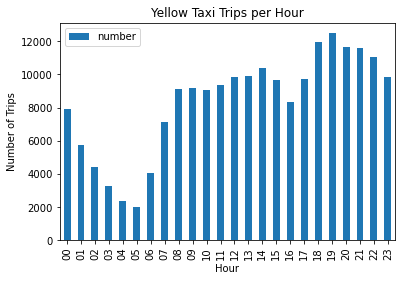

In [67]:
taxi_trip_by_hour()

### Visualization 2
This function shows the average distance traveled per month
In order to find this for both taxis and Ubers combined, we need to create two querys to get taxi and uber data seperatly from two tables

In [91]:
QUERY_taxi = """SELECT strftime('%Y-%m', pickup_datetime) AS month, SUM(distance) AS distance
                FROM taxi_trips
                GROUP BY month
             """
QUERY_uber =  """SELECT strftime('%Y-%m', pickup_datetime) AS month, SUM(distance) AS distance
                FROM uber_trips
               GROUP BY month
             """

In [144]:
def average_distance_month():
    # use the function read_sql_query to pull out values needed to plot and make it a dataframe
    df_taxi = pd.read_sql_query(QUERY_taxi, engine)
    df_uber = pd.read_sql_query(QUERY_uber, engine)
    
    df_taxi['month'] = pd.to_datetime(df_taxi['month'], format='%Y-%m')
    df_uber['month'] = pd.to_datetime(df_uber['month'], format='%Y-%m')

    taxi_info =df_taxi['distance'].groupby(df_taxi['month'].dt.month).agg(['mean','count','sem'])
    uber_info =df_uber['distance'].groupby(df_uber['month'].dt.month).agg(['mean','count','sem'])
    taxi_low, taxi_high = st.t.interval(0.90,taxi_info['count']-1 , loc=taxi_info['mean'], scale=taxi_info['sem'])
    uber_low, uber_high = st.t.interval(0.90, uber_info['count']-1, loc=uber_info['mean'], scale=uber_info['sem'])
    taxi_info['mean'].plot( color='orange', label='Taxi',ylabel = 'Average Distance')
    uber_info['mean'].plot( color='purple', label='Uber',ylabel = 'Average Distance')
    plt.fill_between(taxi_info.index, taxi_low, taxi_high, color='orange', alpha=0.2)
    plt.fill_between(uber_info.index, uber_low, uber_high, color='purple', alpha=0.2)
    plt.title('Average Distance per Month')
    plt.legend()

   
    plt.show()

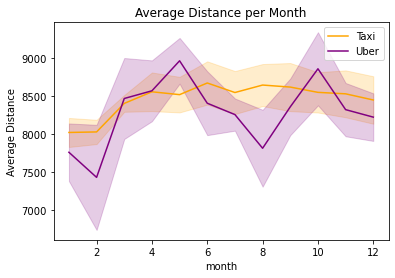

In [145]:
average_distance_month()

### Visualization 3

We found three lat/long coordinate boxes around the three major New York airports: LGA, JFK, and EWR.
Created a visualization that compares what day of the week was most popular for drop offs for each airport.


In [252]:
EWR = [-74.192390,40.670047,-74.153337,40.707844,'EWR']
JFK=  [ -73.823776,40.620946,-73.747559,40.665083,'JFK']
LGA = [  -73.889329,40.766710,-73.854761,40.786449,'LGA']

In [253]:
df = []
for place in [EWR,JFK,LGA]:
    query_place = f'''WITH trips AS (SELECT pickup_datetime, dropoff_longitude, dropoff_latitude FROM taxi_trips
                UNION ALL SELECT pickup_datetime,dropoff_longitude,dropoff_latitude FROM uber_trips)

                    SELECT strftime('%w', pickup_datetime) AS day ,COUNT(*) AS {place[4]}
                    FROM trips
                    WHERE dropoff_longitude BETWEEN {place[0]} AND {place[2]} AND dropoff_latitude BETWEEN {place[1]} AND {place[3]}
                    GROUP BY day
          '''
    df.append(pd.read_sql_query(query_place, engine))




<AxesSubplot:title={'center':'Dropoffs for Each Airport in Each Day of a Week'}, xlabel='Day', ylabel='Number of Dropoffs'>

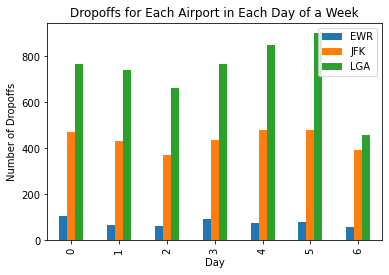

In [254]:
JFK = df[1]['JFK']
EWR =df[0]['EWR']
LGA =df[2]['LGA']
df[0]['JFK'] = df[1]['JFK']
df[0]['LGA'] = df[2]['LGA']

df[0].plot(x="day", y=['EWR','JFK','LGA'], kind="bar", title="Dropoffs for Each Airport in Each Day of a Week", xlabel="Day", ylabel="Number of Dropoffs")

### Visualization 4
Create a heatmap of all hired trips over a map of the area. 

In [368]:
query = '''SELECT pickup_longitude, pickup_latitude
           FROM taxi_trips
           UNION ALL
           SELECT pickup_longitude, pickup_latitude
           FROM uber_trips
        '''
df = pd.read_sql_query(query, engine)
zones = taxi_zones_df.copy()
zones = zones[['LocationID','geometry']]
df = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.pickup_longitude, df.pickup_latitude))
result = zones.sjoin(df, how='left')
result = result.set_index('LocationID')

/Users/wangyanyi/opt/anaconda3/lib/python3.8/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)


In [371]:
result

,geometry,index_right,pickup_longitude,pickup_latitude
LocationID,,,,
1,"POLYGON ((-74.18445 40.69500, -74.18449 40.695...",384894.0,-74.183084,40.687889
1,"POLYGON ((-74.18445 40.69500, -74.18449 40.695...",51429.0,-74.183013,40.687921
1,"POLYGON ((-74.18445 40.69500, -74.18449 40.695...",232013.0,-74.183547,40.688582
1,"POLYGON ((-74.18445 40.69500, -74.18449 40.695...",84514.0,-74.183644,40.688645
1,"POLYGON ((-74.18445 40.69500, -74.18449 40.695...",36830.0,-74.183832,40.688960
...,...,...,...,...
263,"POLYGON ((-73.95219 40.77302, -73.95269 40.772...",205412.0,-73.954938,40.773308
263,"POLYGON ((-73.95219 40.77302, -73.95269 40.772...",140120.0,-73.954992,40.773313
263,"POLYGON ((-73.95219 40.77302, -73.95269 40.772...",261744.0,-73.954796,40.773319


In [379]:
result['num'] = result.groupby('LocationID')['geometry'].count()
result['log_num'] = np.log(result['num'])

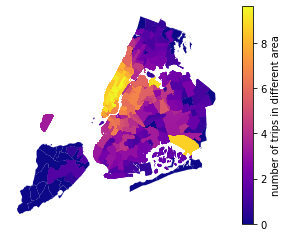

In [380]:

result.plot(column='log_num', cmap='plasma', legend=True, legend_kwds={'label': "number of trips in different area"})
plt.axis('off')
plt.show()

### Visualization 5
CreateD a scatter plot that compares tip amount versus distance.

<AxesSubplot:title={'center':'Tip Amount with Distance'}, xlabel='distance', ylabel='tip_amount'>

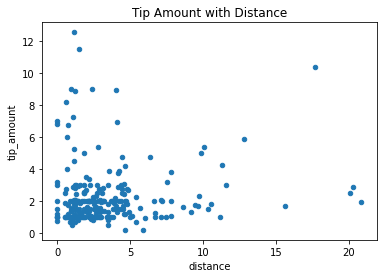

In [307]:
QUERY = """ SELECT tip_amount,distance
            FROM taxi_trips      
        """
df = pd.read_sql_query(QUERY, engine)
    
# sample the data to make the scatter plot clearer
df =df.sample(500)
df = df[df['distance'] < 100]
df =df[df['tip_amount'] > 0]
df.plot(x="distance", y="tip_amount", kind="scatter", title="Tip Amount with Distance", xlabel="Distance", ylabel="Tip Amount")


### Visualization 5
Created another scatter plot that compares tip amount versus precipitation amount for Yellow Taxi rides. You may remove any outliers how you see fit.

In [322]:
query_tip ="""SELECT strftime('%Y-%m-%d %H', pickup_datetime) AS DATE, tip_amount
            FROM taxi_trips
            """ 
query_precipitation ="""SELECT strftime('%Y-%m-%d %H', datetime) as DATE, hourly_precipitation
            FROM hourly_weather
            """

In [342]:
df_tip = pd.read_sql_query(query_tip, engine)
df_precipitation =pd.read_sql_query(query_precipitation, engine)
df = df_tip.merge(df_precipitation,on = 'DATE').sample(2000)
df = df[df['hourly_precipitation'] >0]
df =df[df['tip_amount'] > 0]


<AxesSubplot:title={'center':'Tip Amount and Precipitation'}, xlabel='tip_amount', ylabel='hourly_precipitation'>

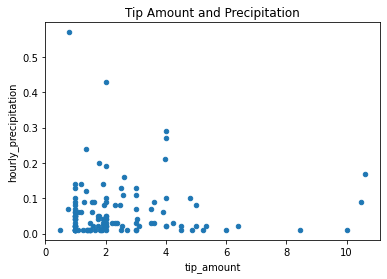

In [351]:
df.plot(x="tip_amount", y="hourly_precipitation", kind="scatter", title="Tip Amount and Precipitation", 
        xlabel="Tip Amount", ylabel="Hourly Precipitation")